In [1]:
import numpy as np
import pandas as pd
from onnxconverter_common import FloatTensorType
from skl2onnx.common.data_types import Int64TensorType, DoubleTensorType, StringTensorType
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 表路径
path1 = "/home/uw1/snippets/py_onnx/expedia/data/S_listings.csv"
path2 = "/home/uw1/snippets/py_onnx/expedia/data/R1_hotels.csv"
path3 = "/home/uw1/snippets/py_onnx/expedia/data/R2_searches.csv"
# 读取csv表
S_listings = pd.read_csv(path1)
R1_hotels = pd.read_csv(path2)
R2_searches = pd.read_csv(path3)
# 连接3张表
data = pd.merge(pd.merge(S_listings, R1_hotels, how='inner'), R2_searches, how='inner')
# print(data.isnull().any())    #检测缺失值
data.dropna(inplace=True)  # 删除NaN

# 获取分类label
y = np.array(data.loc[:, 'promotion_flag'])
# 8 numerical, 20 categorical
numerical_columns = ['prop_location_score1', 'prop_location_score2', 'prop_log_historical_price', 'price_usd',
                     'orig_destination_distance', 'prop_review_score', 'avg_bookings_usd', 'stdev_bookings_usd']
categorical_columns = ['position', 'prop_country_id', 'prop_starrating', 'prop_brand_bool', 'count_clicks',
                       'count_bookings', 'year', 'month', 'weekofyear', 'time', 'site_id',
                       'visitor_location_country_id',
                       'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window',
                       'srch_adults_count',
                       'srch_children_count', 'srch_room_count', 'srch_saturday_night_bool',
                       'random_bool']

X = data.loc[:, numerical_columns+categorical_columns]

input_columns = numerical_columns + categorical_columns

type_map = {
    "int64": Int64TensorType([None, 1]),
    "float64": FloatTensorType([None, 1]),
    "object": StringTensorType([None, 1]),
}


init_types = [(elem, type_map[data[elem].dtype.name]) for elem in input_columns]

In [2]:
numerical_preprocessor = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
    ],
    verbose=True
)

normal_preprocessor = Pipeline(
    steps=[
        ("onehot", OneHotEncoder()),
    ],
    verbose=True
)

preprocessor = ColumnTransformer(
    [
        ("numerical", numerical_preprocessor, numerical_columns),
        ("categorical", normal_preprocessor, categorical_columns),
    ],
    verbose=True,
)

model_lr = make_pipeline(preprocessor, LogisticRegression(solver='liblinear'))
model_lr

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())],
                                                           verbose=True),
                                                  ['prop_location_score1',
                                                   'prop_location_score2',
                                                   'prop_log_historical_price',
                                                   'price_usd',
                                                   'orig_destination_distance',
                                                   'prop_review_score',
                                                   'avg_bookings_usd',
                                                   'stdev_bookings_usd']),
                                                 ('categorical',
                                                  Pipeline(steps=[(...
                                                   'count_clicks',
                                                   'count_bookings', 'year',
                                                   'month', 'weekofyear',
                                                   'time', 'site_id',
                                                   'visitor_location_country_id',
                                                   'srch_destination_id',
                                                   'srch_length_of_stay',
                                                   'srch_booking_window',
                                                   'srch_adults_count',
                                                   'srch_children_count',
                                                   'srch_room_count',
                                                   'srch_saturday_night_bool',
                                                   'random_bool'])],
                                   verbose=True)),
                ('logisticregression', LogisticRegression(solver='liblinear'))])

In [3]:
model_lr.fit(X, y)

print("Training done.")

[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.1s
[ColumnTransformer] ..... (1 of 2) Processing numerical, total=   0.1s
[Pipeline] ............ (step 1 of 1) Processing onehot, total=   1.2s
[ColumnTransformer] ... (2 of 2) Processing categorical, total=   1.2s
Training done.


In [4]:
from sklearn.linear_model import SGDClassifier

model_linear = make_pipeline(preprocessor,  SGDClassifier())
model_linear

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())],
                                                           verbose=True),
                                                  ['prop_location_score1',
                                                   'prop_location_score2',
                                                   'prop_log_historical_price',
                                                   'price_usd',
                                                   'orig_destination_distance',
                                                   'prop_review_score',
                                                   'avg_bookings_usd',
                                                   'stdev_bookings_usd']),
                                                 ('categorical',
                                                  Pipeline(steps=[(...
                                                   'prop_starrating',
                                                   'prop_brand_bool',
                                                   'count_clicks',
                                                   'count_bookings', 'year',
                                                   'month', 'weekofyear',
                                                   'time', 'site_id',
                                                   'visitor_location_country_id',
                                                   'srch_destination_id',
                                                   'srch_length_of_stay',
                                                   'srch_booking_window',
                                                   'srch_adults_count',
                                                   'srch_children_count',
                                                   'srch_room_count',
                                                   'srch_saturday_night_bool',
                                                   'random_bool'])],
                                   verbose=True)),
                ('sgdclassifier', SGDClassifier())])

In [5]:
model_linear.fit(X, y)

print("Training done.")

[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.1s
[ColumnTransformer] ..... (1 of 2) Processing numerical, total=   0.1s
[Pipeline] ............ (step 1 of 1) Processing onehot, total=   1.3s
[ColumnTransformer] ... (2 of 2) Processing categorical, total=   1.3s
Training done.


In [6]:
import onnxoptimizer.query.pandas
import pandas as pd
from onnxoptimizer.query.onnx_eval.model_context import ModelContext

predict_df = X[:200000]

predict_df

,prop_location_score1,prop_location_score2,prop_log_historical_price,price_usd,orig_destination_distance,prop_review_score,avg_bookings_usd,stdev_bookings_usd,position,prop_country_id,...,site_id,visitor_location_country_id,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,random_bool
0,2.20,0.0472,0.00,80.0,86.59,3.5,172.605500,86.693494,'1','219',...,'5','219','13233',2,0,2,0,1,1,0
1,2.56,0.0221,0.00,75.0,82.51,4.5,277.470000,77.690000,'1','219',...,'5','219','13233',2,0,2,0,1,1,0
2,2.56,0.0863,0.00,89.0,91.15,4.0,124.185714,62.019917,'1','219',...,'5','219','13233',2,0,2,0,1,1,0
3,2.20,0.0104,0.00,40.0,87.17,2.5,103.603333,83.719086,'1','219',...,'5','219','13233',2,0,2,0,1,1,0
4,0.69,0.0138,0.00,65.0,85.21,4.0,113.760000,30.520000,'1','219',...,'5','219','13233',2,0,2,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,5.16,0.6970,5.23,80.0,0.00,3.5,461.574167,294.988622,'0','219',...,'5','202','25556',2,1,1,0,1,1,0
199996,5.11,0.5471,5.80,159.0,0.00,4.5,743.035000,548.964640,'0','219',...,'5','202','25556',2,1,1,0,1,1,0
199997,5.18,0.8700,5.52,139.0,0.00,4.5,655.888438,314.040378,'0','219',...,'5','202','25556',2,1,1,0,1,1,0
199998,5.18,0.8320,5.39,127.0,0.00,4.5,536.253333,441.178370,'0','219',...,'5','202','25556',2,1,1,0,1,1,0


In [7]:
# declare model inference context function.
mc_lr = ModelContext(model_lr)
mc_linear = ModelContext(model_linear)

args_string = ','.join([
    f'{elem}={elem}'
    for elem in input_columns
])

# inference query string.
eval_str = f'''result_lr=@mc_lr({args_string})
result_linear=@mc_linear({args_string})
'''
print(eval_str)

result_lr=@mc_lr(prop_location_score1=prop_location_score1,prop_location_score2=prop_location_score2,prop_log_historical_price=prop_log_historical_price,price_usd=price_usd,orig_destination_distance=orig_destination_distance,prop_review_score=prop_review_score,avg_bookings_usd=avg_bookings_usd,stdev_bookings_usd=stdev_bookings_usd,position=position,prop_country_id=prop_country_id,prop_starrating=prop_starrating,prop_brand_bool=prop_brand_bool,count_clicks=count_clicks,count_bookings=count_bookings,year=year,month=month,weekofyear=weekofyear,time=time,site_id=site_id,visitor_location_country_id=visitor_location_country_id,srch_destination_id=srch_destination_id,srch_length_of_stay=srch_length_of_stay,srch_booking_window=srch_booking_window,srch_adults_count=srch_adults_count,srch_children_count=srch_children_count,srch_room_count=srch_room_count,srch_saturday_night_bool=srch_saturday_night_bool,random_bool=random_bool)
result_linear=@mc_linear(prop_location_score1=prop_location_score1,p

In [8]:
import time

start = time.perf_counter()
result_df = predict_df.predict_eval(eval_str)
stop = time.perf_counter()
time_opt = stop - start

result_df[["result_lr", "result_linear"]]

This is my expr eval patching into pandas.


,result_lr,result_linear
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
199995,1,0
199996,1,0
199997,1,1
199998,0,0


In [9]:
start = time.perf_counter()
result_df2 = predict_df.eval(eval_str)
stop = time.perf_counter()

time_un_opt = stop - start
result_df2[["result_lr", "result_linear"]]

,result_lr,result_linear
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
199995,1,0
199996,1,0
199997,1,1
199998,0,0


In [10]:
time_opt, time_un_opt

(2.454294539998955, 4.599414092999723)

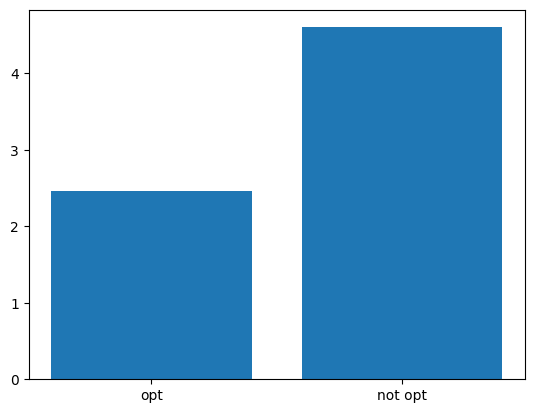

In [11]:
y = [time_opt, time_un_opt]
x = [1, 2]

x_label=['opt','not opt']
plt.xticks(x, x_label)
plt.bar(x, y)
plt.show()